In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch import autograd

import torchvision
import matplotlib.pyplot as plt
import numpy as np

import time

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnst", train=True, transform=torchvision.transforms.ToTensor(), download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw


  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw


  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw


  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw
Processing...
Done!


/opt/miniconda3/envs/neural-py37/lib/python3.7/site-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1614378044816/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True)

In [ ]:
len(dataloader)

3750

In [ ]:
for image, cat in dataloader:
    break

In [ ]:
image.size()

torch.Size([16, 1, 32, 32])

In [ ]:
28*28

784

### Create generator and discriminator

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [ ]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [ ]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data).view(images.shape[0])
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.20 errD_z: 0.14 errG: 2.17
Epoch:1 Iter: 200 errD_x: 0.23 errD_z: 0.16 errG: 2.39
Epoch:1 Iter: 300 errD_x: 0.28 errD_z: 0.15 errG: 2.16
Epoch:1 Iter: 400 errD_x: 0.17 errD_z: 0.08 errG: 2.76
Epoch:1 Iter: 500 errD_x: 0.13 errD_z: 0.06 errG: 2.90
Epoch:1 Iter: 600 errD_x: 0.08 errD_z: 0.09 errG: 2.62
Epoch:1 Iter: 700 errD_x: 0.08 errD_z: 0.05 errG: 3.29
Epoch:1 Iter: 800 errD_x: 0.08 errD_z: 0.14 errG: 2.70
Epoch:1 Iter: 900 errD_x: 0.19 errD_z: 0.13 errG: 2.51
Epoch:1 Iter: 1000 errD_x: 0.07 errD_z: 0.20 errG: 2.00
Epoch:1 Iter: 1100 errD_x: 0.22 errD_z: 0.26 errG: 1.70
Epoch:1 Iter: 1200 errD_x: 0.31 errD_z: 0.17 errG: 2.09
Epoch:1 Iter: 1300 errD_x: 0.11 errD_z: 0.09 errG: 2.66
Epoch:1 Iter: 1400 errD_x: 0.04 errD_z: 0.25 errG: 1.88
Epoch:1 Iter: 1500 errD_x: 0.24 errD_z: 0.24 errG: 1.88
Epoch:1 Iter: 1600 errD_x: 0.04 errD_z: 0.24 errG: 2.05
Epoch:1 Iter: 1700 errD_x: 0.15 errD_z: 0.23 errG: 1.89
Epoch:1 Iter: 1800 errD_x: 0.08 errD_z: 0.25 errG: 2.17
E

Epoch:4 Iter: 3700 errD_x: 0.38 errD_z: 0.13 errG: 2.15
Epoch:5 Iter: 100 errD_x: 0.10 errD_z: 0.17 errG: 1.86
Epoch:5 Iter: 200 errD_x: 0.35 errD_z: 0.11 errG: 2.64
Epoch:5 Iter: 300 errD_x: 0.34 errD_z: 0.19 errG: 2.47
Epoch:5 Iter: 400 errD_x: 0.34 errD_z: 0.09 errG: 3.29
Epoch:5 Iter: 500 errD_x: 0.18 errD_z: 0.17 errG: 3.17
Epoch:5 Iter: 600 errD_x: 0.11 errD_z: 0.15 errG: 2.21
Epoch:5 Iter: 700 errD_x: 0.64 errD_z: 0.16 errG: 2.63
Epoch:5 Iter: 800 errD_x: 0.29 errD_z: 0.18 errG: 3.24
Epoch:5 Iter: 900 errD_x: 0.02 errD_z: 0.39 errG: 1.92
Epoch:5 Iter: 1000 errD_x: 0.26 errD_z: 0.15 errG: 2.00
Epoch:5 Iter: 1100 errD_x: 0.27 errD_z: 0.06 errG: 3.45
Epoch:5 Iter: 1200 errD_x: 0.18 errD_z: 0.45 errG: 1.53
Epoch:5 Iter: 1300 errD_x: 0.24 errD_z: 0.50 errG: 1.23
Epoch:5 Iter: 1400 errD_x: 0.12 errD_z: 0.13 errG: 3.07
Epoch:5 Iter: 1500 errD_x: 0.36 errD_z: 0.13 errG: 2.20
Epoch:5 Iter: 1600 errD_x: 0.03 errD_z: 0.78 errG: 1.32
Epoch:5 Iter: 1700 errD_x: 0.80 errD_z: 0.19 errG: 2.08
E

Epoch:8 Iter: 3600 errD_x: 0.14 errD_z: 0.31 errG: 1.46
Epoch:8 Iter: 3700 errD_x: 0.39 errD_z: 0.24 errG: 2.41
Epoch:9 Iter: 100 errD_x: 0.40 errD_z: 0.38 errG: 1.68
Epoch:9 Iter: 200 errD_x: 0.45 errD_z: 0.56 errG: 1.13
Epoch:9 Iter: 300 errD_x: 0.74 errD_z: 0.54 errG: 1.38
Epoch:9 Iter: 400 errD_x: 0.51 errD_z: 0.31 errG: 1.73
Epoch:9 Iter: 500 errD_x: 0.61 errD_z: 0.23 errG: 2.08
Epoch:9 Iter: 600 errD_x: 0.60 errD_z: 0.11 errG: 3.00
Epoch:9 Iter: 700 errD_x: 0.79 errD_z: 0.33 errG: 1.51
Epoch:9 Iter: 800 errD_x: 0.73 errD_z: 0.28 errG: 2.12
Epoch:9 Iter: 900 errD_x: 0.61 errD_z: 0.10 errG: 3.01
Epoch:9 Iter: 1000 errD_x: 0.35 errD_z: 0.26 errG: 2.17
Epoch:9 Iter: 1100 errD_x: 0.17 errD_z: 0.22 errG: 1.96
Epoch:9 Iter: 1200 errD_x: 0.11 errD_z: 0.16 errG: 2.22
Epoch:9 Iter: 1300 errD_x: 0.33 errD_z: 0.18 errG: 2.54
Epoch:9 Iter: 1400 errD_x: 0.03 errD_z: 0.49 errG: 1.90
Epoch:9 Iter: 1500 errD_x: 0.76 errD_z: 0.22 errG: 2.31
Epoch:9 Iter: 1600 errD_x: 0.46 errD_z: 0.23 errG: 2.51
E

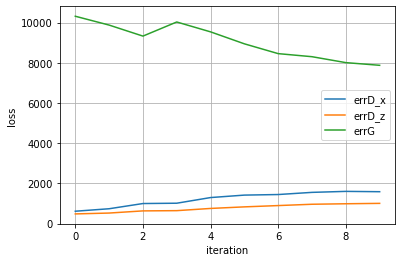

In [ ]:
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(ERRD_x, label='errD_x')
plt.plot(ERRD_z, label='errD_z')
plt.plot(ERRG, label='errG')
plt.legend()
plt.grid()
plt.show()

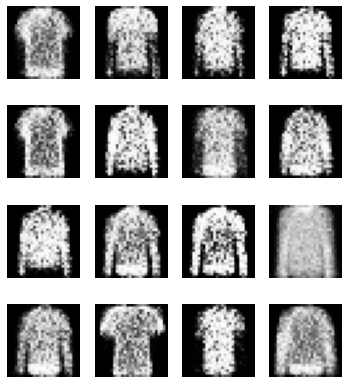

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

__1. Интерполяция__

In [ ]:
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return vectors

In [ ]:
def plot_generated_grey(examples, n):
    for i in range(n):
        # define subplot
        plt.subplot(1, n, 1 + i)
        # turn off axis
        plt.axis('off')
        plt.imshow(examples[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.show()

1. Берем две точки из латентного пространства
2. Применяем интерполяцию
3. Генерируем изображения

In [ ]:
batch = noise.data.normal_(0, 1)
points = [batch[0], batch[1]]

In [ ]:
points = interpolate_points(points[0], points[1])
interpolated_points = torch.zeros(size=(len(points), config.noise_size))
for i in range(len(points)):
    interpolated_points[i] = points[i]

In [ ]:
generator.eval()
with torch.no_grad():
    interpolated_imgs = generator(interpolated_points)

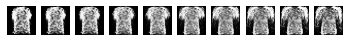

In [ ]:
plot_generated_grey(interpolated_imgs, 10)

In [ ]:
def plot_generated(examples, n):
    for i in range(n):
        # define subplot
        plt.subplot(1, n, 1 + i)
        # turn off axis
        plt.axis('off')
        plt.imshow(examples[i].detach().numpy().reshape(28, 28))
    plt.show()

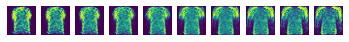

In [ ]:
plot_generated(interpolated_imgs, 10)

__2. Хочу DCGAN__

In [ ]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)),
                                                                                            torchvision.transforms.ToTensor()]),
                                                                                            download=True)

In [ ]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.ngf = 64
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(100, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( self.ngf * 2, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.ndf = 64
        self.model = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(1, self.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(self.ndf * 4, 1, 4, 2, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
config.noise_size = 100
config.num_epochs = 5

In [ ]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [ ]:
input = Variable(torch.FloatTensor(config.batch_size, 32*32))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, 1, 1))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, 1, 1).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], 1, 32, 32)
        output = discriminator(input_data).view(images.shape[0])
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.5f} errD_z: {:.5f} errG: {:.5f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.00120 errD_z: 0.00137 errG: 6.71272
Epoch:1 Iter: 200 errD_x: 0.00093 errD_z: 0.00067 errG: 7.44885
Epoch:1 Iter: 300 errD_x: 0.00034 errD_z: 0.00086 errG: 7.25337
Epoch:1 Iter: 400 errD_x: 0.00071 errD_z: 0.00039 errG: 7.92290
Epoch:1 Iter: 500 errD_x: 0.00038 errD_z: 0.00014 errG: 8.89577
Epoch:1 Iter: 600 errD_x: 0.00004 errD_z: 0.00032 errG: 8.12524
Epoch:1 Iter: 700 errD_x: 0.00032 errD_z: 0.00055 errG: 7.67998
Epoch:1 Iter: 800 errD_x: 0.00021 errD_z: 0.00035 errG: 8.04658
Epoch:1 Iter: 900 errD_x: 0.00018 errD_z: 0.00034 errG: 8.07100
Epoch:1 Iter: 1000 errD_x: 0.00020 errD_z: 0.00018 errG: 8.67697
Epoch:1 Iter: 1100 errD_x: 0.00031 errD_z: 0.00078 errG: 7.35511
Epoch:1 Iter: 1200 errD_x: 0.00027 errD_z: 0.00050 errG: 7.98286
Epoch:1 Iter: 1300 errD_x: 0.00009 errD_z: 0.00031 errG: 8.16899
Epoch:1 Iter: 1400 errD_x: 0.00064 errD_z: 0.00837 errG: 6.09244
Epoch:1 Iter: 1500 errD_x: 0.00007 errD_z: 0.00030 errG: 8.25170
Epoch:1 Iter: 1600 errD_x: 0.00036

Epoch:4 Iter: 1700 errD_x: 0.01969 errD_z: 0.00229 errG: 6.21274
Epoch:4 Iter: 1800 errD_x: 0.01208 errD_z: 0.01448 errG: 4.60312
Epoch:4 Iter: 1900 errD_x: 0.00495 errD_z: 0.00582 errG: 5.92914
Epoch:4 Iter: 2000 errD_x: 0.00191 errD_z: 0.11070 errG: 2.94339
Epoch:4 Iter: 2100 errD_x: 0.00414 errD_z: 0.01224 errG: 5.46184
Epoch:4 Iter: 2200 errD_x: 0.00202 errD_z: 0.04288 errG: 3.98967
Epoch:4 Iter: 2300 errD_x: 0.00820 errD_z: 0.01246 errG: 5.48554
Epoch:4 Iter: 2400 errD_x: 0.03837 errD_z: 0.04260 errG: 3.87802
Epoch:4 Iter: 2500 errD_x: 0.00200 errD_z: 0.02975 errG: 4.52465
Epoch:4 Iter: 2600 errD_x: 0.00212 errD_z: 0.00717 errG: 5.91188
Epoch:4 Iter: 2700 errD_x: 0.02905 errD_z: 0.06583 errG: 4.85750
Epoch:4 Iter: 2800 errD_x: 0.00625 errD_z: 0.00357 errG: 6.60787
Epoch:4 Iter: 2900 errD_x: 0.03309 errD_z: 0.00215 errG: 7.11968
Epoch:4 Iter: 3000 errD_x: 0.00077 errD_z: 0.04749 errG: 3.66900
Epoch:4 Iter: 3100 errD_x: 0.00352 errD_z: 0.00419 errG: 7.02452
Epoch:4 Iter: 3200 errD_x

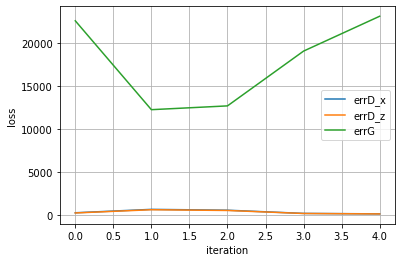

In [ ]:
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(ERRD_x, label='errD_x')
plt.plot(ERRD_z, label='errD_z')
plt.plot(ERRG, label='errG')
plt.legend()
plt.grid()
plt.show()

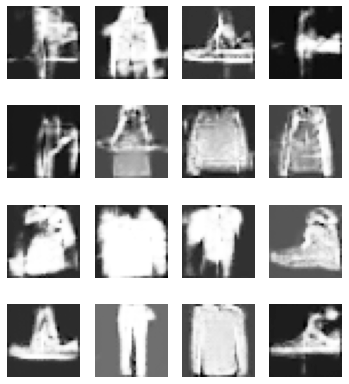

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
    plt.axis('off')

Некоторые картинки получились даже не плохо, а вот многие совсем ни на что не похожи..

__3. LSGAN__

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 32 // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(1, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = 32 // 2 ** 4
        self.adv_layer = nn.Linear(128 * ds_size ** 2, 1)

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity

In [ ]:
generator = Generator()
discriminator = Discriminator()

In [ ]:
config.noise_size = 100
config.num_epochs = 5

In [ ]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.MSELoss()

In [ ]:
input = Variable(torch.FloatTensor(config.batch_size, 32*32))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size, 1, 1).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

In [ ]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], 1, 32, 32)
        output = discriminator(input_data).view(images.shape[0])
        errD_x = criterion(output, label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach()).view(-1)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.41 errD_z: 0.18 errG: 0.37
Epoch:1 Iter: 200 errD_x: 0.36 errD_z: 0.22 errG: 0.29
Epoch:1 Iter: 300 errD_x: 0.22 errD_z: 0.18 errG: 0.39
Epoch:1 Iter: 400 errD_x: 0.29 errD_z: 0.26 errG: 0.24
Epoch:1 Iter: 500 errD_x: 0.25 errD_z: 0.17 errG: 0.39
Epoch:1 Iter: 600 errD_x: 0.22 errD_z: 0.20 errG: 0.28
Epoch:1 Iter: 700 errD_x: 0.28 errD_z: 0.26 errG: 0.26
Epoch:1 Iter: 800 errD_x: 0.24 errD_z: 0.20 errG: 0.28
Epoch:1 Iter: 900 errD_x: 0.24 errD_z: 0.21 errG: 0.29
Epoch:1 Iter: 1000 errD_x: 0.26 errD_z: 0.25 errG: 0.27
Epoch:1 Iter: 1100 errD_x: 0.25 errD_z: 0.19 errG: 0.31
Epoch:1 Iter: 1200 errD_x: 0.20 errD_z: 0.28 errG: 0.23
Epoch:1 Iter: 1300 errD_x: 0.28 errD_z: 0.25 errG: 0.33
Epoch:1 Iter: 1400 errD_x: 0.21 errD_z: 0.30 errG: 0.28
Epoch:1 Iter: 1500 errD_x: 0.26 errD_z: 0.28 errG: 0.32
Epoch:1 Iter: 1600 errD_x: 0.23 errD_z: 0.26 errG: 0.30
Epoch:1 Iter: 1700 errD_x: 0.25 errD_z: 0.24 errG: 0.23
Epoch:1 Iter: 1800 errD_x: 0.13 errD_z: 0.24 errG: 0.27
E

Epoch:4 Iter: 3700 errD_x: 0.05 errD_z: 0.25 errG: 0.35
Epoch:5 Iter: 100 errD_x: 0.12 errD_z: 0.52 errG: 0.43
Epoch:5 Iter: 200 errD_x: 0.09 errD_z: 0.24 errG: 0.39
Epoch:5 Iter: 300 errD_x: 0.04 errD_z: 0.20 errG: 0.35
Epoch:5 Iter: 400 errD_x: 0.41 errD_z: 0.11 errG: 0.53
Epoch:5 Iter: 500 errD_x: 0.15 errD_z: 0.19 errG: 0.54
Epoch:5 Iter: 600 errD_x: 0.48 errD_z: 0.32 errG: 0.51
Epoch:5 Iter: 700 errD_x: 0.19 errD_z: 0.22 errG: 0.54
Epoch:5 Iter: 800 errD_x: 0.15 errD_z: 0.46 errG: 0.39
Epoch:5 Iter: 900 errD_x: 0.20 errD_z: 0.15 errG: 0.17
Epoch:5 Iter: 1000 errD_x: 0.07 errD_z: 0.16 errG: 0.50
Epoch:5 Iter: 1100 errD_x: 0.12 errD_z: 0.02 errG: 0.91
Epoch:5 Iter: 1200 errD_x: 0.10 errD_z: 0.14 errG: 0.45
Epoch:5 Iter: 1300 errD_x: 0.20 errD_z: 0.03 errG: 0.43
Epoch:5 Iter: 1400 errD_x: 0.18 errD_z: 0.16 errG: 0.21
Epoch:5 Iter: 1500 errD_x: 0.19 errD_z: 0.16 errG: 0.86
Epoch:5 Iter: 1600 errD_x: 0.11 errD_z: 0.15 errG: 0.67
Epoch:5 Iter: 1700 errD_x: 0.09 errD_z: 0.20 errG: 0.46
E

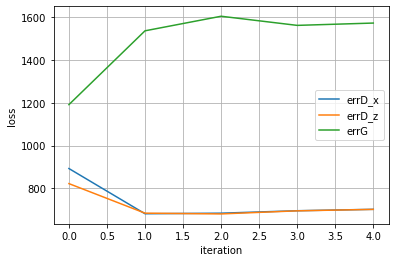

In [ ]:
plt.xlabel('iteration')
plt.ylabel('loss')
plt.plot(ERRD_x, label='errD_x')
plt.plot(ERRD_z, label='errD_z')
plt.plot(ERRG, label='errG')
plt.legend()
plt.grid()
plt.show()

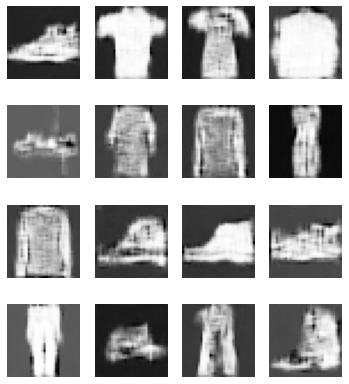

In [ ]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(32, 32), cmap=plt.cm.Greys_r)
    plt.axis('off')

__4.Условная генерация__

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnst", train=True, transform=torchvision.transforms.ToTensor(), download=True)


Extracting fashion_mnst/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnst/FashionMNIST/raw




Extracting fashion_mnst/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnst/FashionMNIST/raw




Extracting fashion_mnst/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnst/FashionMNIST/raw




Extracting fashion_mnst/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnst/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True)

In [5]:
config.num_epochs = 7
config.noise_size = 100
config.generator_size = 1024
config.critic_size = 1024
config.num_classes = 10
config.n_critic = 5

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.latent_embedding = nn.Sequential(
            nn.Linear(config.noise_size, config.generator_size // 2),
        )
        self.condition_embedding = nn.Sequential(
            nn.Linear(config.num_classes, config.generator_size // 2),
        )
        self.tcnn = nn.Sequential(
            nn.ConvTranspose2d( config.generator_size, config.generator_size, 4, 1, 0),
            nn.BatchNorm2d(config.generator_size),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d( config.generator_size, config.generator_size // 2, 3, 2, 1),
            nn.BatchNorm2d(config.generator_size // 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(config.generator_size // 2, config.generator_size // 4, 4, 2, 1),
            nn.BatchNorm2d(config.generator_size // 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d( config.generator_size // 4, 1, 4, 2, 1),
            nn.Tanh()
        )


    def forward(self, latent, condition):
        vec_latent = self.latent_embedding(latent)
        vec_class = self.condition_embedding(condition)
        combined = torch.cat([vec_latent, vec_class], dim=1).reshape(-1, config.generator_size, 1, 1)
        return self.tcnn(combined)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.condition_embedding = nn.Sequential(
            nn.Linear(config.num_classes, config.critic_size * 4),
        )
        self.cnn_net = nn.Sequential(
            nn.Conv2d(1, config.critic_size // 4, 3, 2),
            nn.InstanceNorm2d(config.critic_size // 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(config.critic_size // 4, config.critic_size // 2, 3, 2),
            nn.InstanceNorm2d(config.critic_size // 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),   
            nn.Conv2d(config.critic_size // 2, config.critic_size, 3, 2),
            nn.InstanceNorm2d(config.critic_size, affine=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
        )
        self.Critic_net = nn.Sequential(
            nn.Linear(config.critic_size * 8, config.critic_size),
            nn.LeakyReLU(0.2, inplace=True),   
            nn.Linear(config.critic_size, 1),
        )
        
    def forward(self, image, condition):
        vec_condition = self.condition_embedding(condition)
        cnn_features = self.cnn_net(image)
        combined = torch.cat([cnn_features, vec_condition], dim=1)
        return self.Critic_net(combined)

In [7]:
critic, generator = Discriminator().to('cuda'), Generator().to('cuda')

critic_optimizer = optim.AdamW(critic.parameters(), lr=1e-4, betas=(0., 0.9))
generator_optimizer = optim.AdamW(generator.parameters(), lr=1e-4, betas=(0., 0.9))

In [8]:
img_list, generator_losses, critic_losses = [], [], []
iters = 0
all_labels = torch.eye(config.num_classes, dtype=torch.float32, device='cuda')
fixed_noise = torch.randn((80, config.noise_size), device='cuda')
fixed_class_labels = all_labels[[i for i in list(range(config.num_classes)) for idx in range(8)]]
grad_tensor = torch.ones((config.batch_size , 1), device='cuda')

start_time = time.time()
for epoch in range(config.num_epochs):
    for batch_idx, data in enumerate(dataloader, 0):
        real_images, real_class_labels = data[0].to('cuda'), all_labels[data[1]].to('cuda')
        
        # Update critic
        critic_optimizer.zero_grad()
        
        critic_output_real = critic(real_images, real_class_labels)
        critic_loss_real = critic_output_real.mean()

        noise = torch.randn((config.batch_size, config.noise_size), device='cuda')
        with torch.no_grad(): fake_image = generator(noise, real_class_labels)
        critic_output_fake = critic(fake_image, real_class_labels)
        critic_loss_fake = critic_output_fake.mean()

        alpha = torch.rand((config.batch_size, 1), device='cuda')
        interpolates = (alpha.view(-1, 1, 1, 1) * real_images + ((1. - alpha.view(-1, 1, 1, 1)) * fake_image)).requires_grad_(True)
        d_interpolates = critic(interpolates, real_class_labels)
        gradients = autograd.grad(d_interpolates, interpolates, grad_tensor, create_graph=True, only_inputs=True)[0]
        gradient_penalty = 10. * ((gradients.view(config.batch_size, -1).norm(dim=1) - 1.) ** 2).mean()

        critic_loss = -critic_loss_real + critic_loss_fake  + gradient_penalty
        
        critic_loss.backward()
        critic_optimizer.step()

        if batch_idx % config.n_critic == 0:
            # Update Generator
            generator_optimizer.zero_grad()
            
            fake_class_labels = all_labels[torch.randint(config.num_classes, size=[config.batch_size])]
            noise = torch.randn((config.batch_size, config.noise_size), device='cuda')
            fake_image = generator(noise, fake_class_labels)
            critic_output_fake = critic(fake_image, fake_class_labels)
            generator_loss = -critic_output_fake.mean()
            
            generator_loss.backward()
            generator_optimizer.step()
        
        # Output training stats
        if batch_idx % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f"[{epoch:>2}/{config.num_epochs}][{iters:>7}][{elapsed_time:8.2f}s]\t"
                  f"d_loss/g_loss: {critic_loss.item():4.2}/{generator_loss.item():4.2}\t")
       
        generator_losses.append(generator_loss.item())
        critic_losses.append(critic_loss.item())
            
        iters += 1


[ 0/7][      0][    0.44s]	d_loss/g_loss:  2.2/0.19	
[ 0/7][    100][   21.20s]	d_loss/g_loss: -1.1/ 3.4	
[ 0/7][    200][   42.06s]	d_loss/g_loss: -0.51/-0.76	
[ 0/7][    300][   63.14s]	d_loss/g_loss: -0.97/-0.079	
[ 0/7][    400][   84.31s]	d_loss/g_loss: 0.55/0.56	
[ 0/7][    500][  105.41s]	d_loss/g_loss:  1.5/-0.84	
[ 0/7][    600][  126.49s]	d_loss/g_loss: 0.25/0.17	
[ 0/7][    700][  147.52s]	d_loss/g_loss: 0.76/0.15	
[ 0/7][    800][  168.52s]	d_loss/g_loss: 0.36/-0.15	
[ 0/7][    900][  189.57s]	d_loss/g_loss: -0.22/-0.34	
[ 0/7][   1000][  210.60s]	d_loss/g_loss: 0.48/-1.0	
[ 0/7][   1100][  231.59s]	d_loss/g_loss: 0.24/-0.68	
[ 0/7][   1200][  252.60s]	d_loss/g_loss:  3.5/-0.53	
[ 0/7][   1300][  273.57s]	d_loss/g_loss: 0.13/-0.97	
[ 0/7][   1400][  294.58s]	d_loss/g_loss: 0.31/-1.0	
[ 0/7][   1500][  315.57s]	d_loss/g_loss: 0.66/-0.73	
[ 0/7][   1600][  336.57s]	d_loss/g_loss: 0.29/-0.96	
[ 0/7][   1700][  357.57s]	d_loss/g_loss: -0.21/-1.4	
[ 0/7][   1800][  378.58s]	d_lo

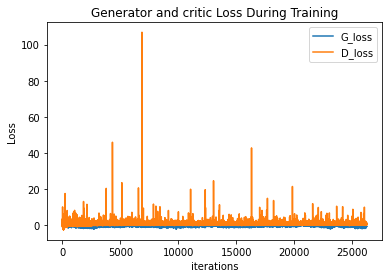

In [9]:
plt.title("Generator and critic Loss During Training")
plt.plot(generator_losses,label="G_loss")
plt.plot(critic_losses,label="D_loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [15]:
generator.to('cuda')

Generator(
  (latent_embedding): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
  )
  (condition_embedding): Sequential(
    (0): Linear(in_features=10, out_features=512, bias=True)
  )
  (tcnn): Sequential(
    (0): ConvTranspose2d(1024, 1024, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Tanh()
  )
)

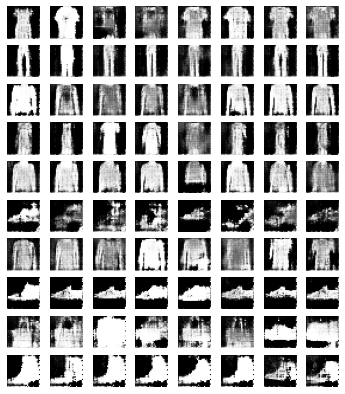

In [18]:
fixed_noise = fixed_noise.to('cuda')
labels = [[i for _ in range(config.batch_size)] for i in range(config.num_classes)]
fake = generator(fixed_noise, fixed_class_labels).cpu()


plt.figure(figsize=(6, 7))
for i in range(fixed_noise.shape[0]):
    plt.subplot(10, 8, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

__4.Отчет__

1. Попробовал архитектуру Convolutional GAN, для некоторых классов получаются вменяемые объекты, но для многих классов, всё равно, генерируется много артефактов. Ну и учится ган очень долго
2. Архитектура LSGAN показала себя лучше всего, многие изображения действительно качественно получились, по поводу скорости работы -- быстрее чем CGAN
3. Сверточные ганы учатся небыстро.. Где-то год назад пробовал еще различные архитектуры ганов на полносвязных слоях, получалось неплохо, некоторые архитектуры привел ниже.
4. По поводу условной генерации, для многих классов изображения получились хорошо, но артефактов всё равно хватает..
5. Так как учить ганы долго, много эпох не делал, но в принципе, более или менее вменяемые результаты получаются уже и на 3-4 эпохах.

In [ ]:
#Discriminator
class Discriminator(nn.Module):
    def __init__(self, inp_dim=3*128*128):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(inp_dim, 1024)
        self.act1 = nn.LeakyReLU(0.2)
        self.dr1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 512)
        self.act2 = nn.LeakyReLU(0.2)
        self.dr2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(512, 256)
        self.act3 = nn.LeakyReLU(0.2)
        self.dr3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(256, 128)
        self.act4 = nn.LeakyReLU(0.2)
        self.dr4 = nn.Dropout(0.3)
        self.fc5 = nn.Linear(128, 32)
        self.act5 = nn.LeakyReLU(0.2)
        self.dr5 = nn.Dropout(0.3)
        self.fc6 = nn.Linear(32, 1)

    def forward(self, x):
        x = x.view(x.size(0), 3*128*128) # flatten (bs x 3 x 150 x 150) -> (bs x 3 * 150 * 150)
        h = self.dr1(self.act1(self.fc1(x)))
        out1 = self.dr2(self.act2(self.fc2(h)))
        out2 = self.dr3(self.act3(self.fc3(out1)))
        out3 = self.dr4(self.act4(self.fc4(out2)))
        out4 = self.dr5(self.act5(self.fc5(out3)))
        out = self.fc6(out4)
        out = torch.sigmoid(out)
        return out

#Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_dim, 128)
        self.act1 = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(128,256)
        self.act2 = nn.LeakyReLU(0.2)
        self.fc3 = nn.Linear(256,512)
        self.act3 = nn.LeakyReLU(0.2)
        self.fc4 = nn.Linear(512, 1024)
        self.act4 = nn.LeakyReLU(0.2)
        self.fc5 = nn.Linear(1024, 3*128*128)

    def forward(self, x):
        h = self.act1(self.fc1(x))
        out1 = self.act2(self.fc2(h))
        out2 = self.act3(self.fc3(out1))
        out3 = self.act4(self.fc4(out2))
        out = self.fc5(out3)
        out = torch.tanh(out) # range [-1, 1]
        # convert to image 
        out = out.view(out.size(0), 3, 128, 128)
        return out